In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [57]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3 ,thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == "x":
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    elif orient =="y":
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    else:
        pass
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel>=thresh_min)&(scaled_sobel<=thresh_max)]=1
    # 6) Return this mask as your binary_output image
    
    binary_output = sbinary # Remove this line
    return binary_output


def color_threshold_HSV(img, color_space,thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    HSV = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    H= HSV[:,:,0]
    S= HSV[:,:,1]
    V = HSV[:,:,2]
    
    if color_space == "H":
        binary = np.zeros_like(H)
        binary[(H>=thresh[0])&(H<=thresh[1])]=1
        retval, color_space_binary = cv2.threshold(H.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
        print("Color Space:",color_space)
    elif color_space=="S":
        binary = np.zeros_like(S)
        binary[(S>=thresh[0])&(S<=thresh[1])]=1
        retval, color_space_binary = cv2.threshold(S.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
        print("Color Space:",color_space)
    elif color_space=="V":
        binary = np.zeros_like(V)
        binary[(V>=thresh[0])&(V<=thresh[1])]=1
        retval, color_space_binary = cv2.threshold(V.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
        print("Color Space:",color_space)
    return color_space_binary

def warp(img):
    img_size=(img.shape[1],img.shape[0])
    src = np.float32( 
                        [[585. /1280.*img_size[0], 455./720.*img_size[1]],
                        [705. /1280.*img_size[0], 455./720.*img_size[1]],
                        [1250./1280.*img_size[0], 720./720.*img_size[1]],
                        [190. /1280.*img_size[0], 720./720.*img_size[1]]])
    dst = np.float32([[300. /1280.*img_size[0], 100./720.*img_size[1]],
                        [1000./1280.*img_size[0], 100./720.*img_size[1]],
                        [1000./1280.*img_size[0], 720./720.*img_size[1]],
                        [300. /1280.*img_size[0], 720./720.*img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped,M,Minv

def color_mask(color_space,low,high):
    mask = cv2.inRange(color_space, low, high)
    return mask
# apply color to the binary image
def apply_color_mask(color_space,img,low,high):
    mask = cv2.inRange(color_space, low, high)
    result = cv2.bitwise_and(img,img, mask= mask)
    return result

def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def lane_detection(lane_line_gb,mean_lane,thresh=0.005,which="left"):
    img_size =(lane_line_gb.shape[1],lane_line_gb.shape[0])
    arg_fsb = np.argwhere(mean_lane>thresh)
  
    if which  == "left":
        arg_fsb_L = arg_fsb[arg_fsb<img_size[0]/2.]
        if len(arg_fsb_L)==0:
            left_fit = left_fit_prev
        else:
            arg_fsb_L_min = np.min(arg_fsb_L)
            arg_fsb_L_max = np.max(arg_fsb_L)
            img_L = np.copy(lane_line_gb)
            img_L[:,0:arg_fsb_L_min] = 0
            img_L[:,arg_fsb_L_max:img_size[0]] = 0
        return img_L

    elif which =="right":
        arg_fsb_R = arg_fsb[arg_fsb>img_size[0]/2.]
        arg_fsb_R_min = np.min(arg_fsb_R)
        arg_fsb_R_max = np.max(arg_fsb_R)
        img_R = np.copy(lane_line_gb)
        img_R[:,0:arg_fsb_R_min] = 0
        img_R[:,arg_fsb_R_max:img_size[0]] = 0
        return img_R
    else:
        pass
    
def polyfit(line,thresh=0.8):
    global left_fit_prev   
    global right_fit_prev
    img_size = (line.shape[1],line.shape[0])
    vals = np.argwhere(line > thresh)
   
    all_x = vals.T[0]
    all_y =vals.T[1]

    fit = np.polyfit(all_x, all_y, 2)    
   
    y = np.arange(11)*img_size[1]/10
    fitx = fit[0] * y**2 + fit[1]*y + fit[2]
    left_fit_prev = left_fit
    return fitx,y,fit

def fit_cr(line,thresh=0.5):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    img_size = (line.shape[1],line.shape[0])
    vals = np.argwhere(line > thresh)
    
    all_x = vals.T[0]
    all_y = vals.T[1]
    
    fit = np.polyfit(all_x*xm_per_pix, all_y*ym_per_pix, 2)
    return fit
 
def get_curvature(pol_a,y_pt):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    A = pol_a[0]
    B = pol_a[1]
    R_curve = (1+(2*A*y_pt*ym_per_pix+B)**2)**1.5/np.absolute(2*A)
    return R_curve
    

In [93]:
def pipeline(img):
    global left_fit_prev   
    global right_fit_prev
    global set_prev
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    img_size=(img.shape[1],img.shape[0])
    mtx=np.array([[  7.52615043e+03,   0.00000000e+00,   4.69192259e+02],
                              [  0.00000000e+00,   7.86343209e+03,   2.73078310e+02],
                             [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
    dist = np.array([[ -9.92700922e+00,  -3.60394577e+02,   1.74434101e-01,
                                  2.34383103e-01,   3.07597893e+04]])
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #warped,M,Minv = warp(img)
    warped,M,Minv = warp(undist)

    image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)
    

    yellow_hsv_low  = np.array([ 0, 65, 80])
    yellow_hsv_high = np.array([ 80, 255, 255])

    white_hsv_low  = np.array([  0,   0,   180])
    white_hsv_high = np.array([ 255,  32, 255])

    yellow_lane = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    white_lane = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    
    sobelx=abs_sobel_thresh(undist)
    #sobelx=abs_sobel_thresh(img)
    
    lane_color = cv2.bitwise_or(yellow_lane,white_lane)
    lane_line = cv2.bitwise_or(sobelx,lane_color)
    lane_line_gb = cv2.GaussianBlur(lane_line,(9,9),0)/255.
    
    
    img_size=(lane_line_gb.shape[1],lane_line_gb.shape[0])
    mov_filtsize = img_size[1]/10.
    mean_lane = np.mean(lane_line_gb,axis=0)
    mean_lane= moving_average(mean_lane,mov_filtsize)

    arg_fsb = np.argwhere(mean_lane>.005)

    arg_fsb_L = arg_fsb[arg_fsb<img_size[0]/2.]
    if len(arg_fsb_L)==0:
        left_fit = left_fit_prev
        
    else:
        arg_fsb_L_min = np.min(arg_fsb_L)
        arg_fsb_L_max = np.max(arg_fsb_L)
        img_L = np.copy(lane_line_gb)
        img_L[:,0:arg_fsb_L_min] = 0
        img_L[:,arg_fsb_L_max:img_size[0]] = 0
    
        vals = np.argwhere(img_L>.08)
        if len(vals)==0:
            left_fit = left_fit_prev
            
        else:

            all_x = vals.T[0]
            all_y =vals.T[1]
            small_left,large_left = np.percentile(all_y,[5,90])
            all_y = all_y[np.where((all_y>small_left) & (all_y<large_left))]
            all_x = all_x[np.where((all_y>small_left) & (all_y<large_left))]
            left_fit = np.polyfit(all_x, all_y, 2)
            left_fit_prev = left_fit
            left_fit_cr = np.polyfit(all_x*ym_per_pix, all_y*xm_per_pix, 2)
            y_eval = np.max(all_x)
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*left_fit_cr[0])
    left_y = np.arange(11)*img_size[1]/10
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    

    arg_fsb_R = arg_fsb[arg_fsb>img_size[0]/2.]
    #print(arg_fsb_R)
    
    if len(arg_fsb_R)==0:
        right_fit = right_fit_prev
        
    else:
        
        arg_fsb_R_min = np.min(arg_fsb_R)
        arg_fsb_R_max = np.max(arg_fsb_R)

        img_R = np.copy(lane_line_gb)
        img_R[:,0:arg_fsb_R_min] = 0
        img_R[:,arg_fsb_R_max:img_size[0]] = 0
    
    

        vals = np.argwhere(img_R>.008)
        if len(vals)==0:
            right_fit = right_fit_prev
        else:
            all_x = vals.T[0]
            all_y =vals.T[1]
            small_right,large_right = np.percentile(all_y,[5,95])
            
            all_y = all_y[np.where((all_y>small_right) & (all_y<large_right))]
            all_x = all_x[np.where((all_y>small_right) & (all_y<large_right))]


            right_fit = np.polyfit(all_x, all_y, 2)
            right_fit_prev = right_fit
            right_fit_cr = np.polyfit(all_x*ym_per_pix, all_y*xm_per_pix, 2)
            y_eval = np.max(all_x)
            right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*right_fit_cr[0])
            
    right_y = np.arange(11)*img_size[1]/10
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]
    
    right_fit_prev =right_fit
    
    if set_prev == 0:
        set_prev = 1
        right_fit_prev = right_fit
        left_fit_prev  = left_fit

    wpb_zero = np.zeros_like(lane_line_gb).astype(np.uint8)
    color_warp = np.dstack((wpb_zero, wpb_zero, wpb_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])

    pts = np.hstack((pts_left, pts_right))
    

    middle = (left_fitx[-1] + right_fitx[-1])//2
    veh_pos = img_size[0]//2
    dist_offset =100* (veh_pos - middle)*xm_per_pix # Positive means the car is  on  the right side , Negative means on left
   


    # Draw the lane onto the warped blank image
    if dist_offset<30:
        cv2.fillPoly(color_warp, np.int_([pts]), (0,0,255))
    else:
        cv2.fillPoly(color_warp, np.int_([pts]), (255,0, 0))
        
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    right_fit_prev = right_fit
    left_fit_prev  = left_fit
    
  
    
    middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
    
    font = cv2.FONT_HERSHEY_COMPLEX
    result = cv2.addWeighted(undist, 1, newwarp, 0.6, 0)
    cv2.putText(result,'Left radius of curvature  = %.2f m'%(left_curverad),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Right radius of curvature = %.2f m'%(right_curverad),(50,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle position : %.2f cm %s from center'%(abs(dist_offset), 'left' if dist_offset < 0 else 'right'),(50,120), 
                        font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result, str_curv, (30, 60), font, 1, (255,0,0), 2)
    #cv2.putText(result, str_offset, (30, 90), font, 1, (255,0,0), 2)
    #result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

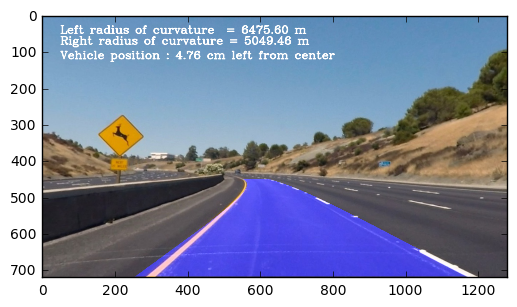

In [94]:
set_prev=0

#image= mpimg.imread('trial_image/082.jpg')
image= mpimg.imread('output_images/test2_undist.jpg')
result = pipeline(image)
plt.imshow(result)

In [91]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'project.mp4'

clip_project = VideoFileClip("project_video.mp4")
project_clip = clip_project.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


100%|█████████▉| 1260/1261 [04:08<00:00,  5.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

CPU times: user 6min 57s, sys: 42.6 s, total: 7min 40s
Wall time: 4min 9s


In [92]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))